0
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
1
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
2
ce stop loss is hit and none were hit till now
ce sl was hit and now other one is also hit
3
pe stop loss is hit and none were hit till now
pe sl was hit and now other one is also hit
4
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
5
ce stop loss is hit and none were hit till now
pe sl was hit and now other exited based on exit time
6
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
7
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
8
pe stop loss is hit and none were hit till now
ce sl was hit and now other exited based on exit time
9
none of the stoplosses were hit and time limit is reached
10
ce stop loss is hit and none were hit till now
pe 

<AxesSubplot:>

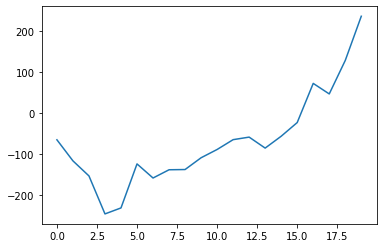

In [41]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dateutil.relativedelta import relativedelta, TH

#fetch all the files from the diretory
path = pd.DataFrame(glob(r'C:\Users\cc\Downloads\sample_nfo_2019-20_data\*'),columns=['location'])
path['data_date'] = path['location'].apply(lambda x: x.split('_')[-1].split('.')[0])
path['data_date'] = path['data_date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
path = path.sort_values(['data_date'])
path.reset_index(drop=True,inplace=True)

intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','Future_Traded_Price','ATM','Days_to_Expiry','CE_Symbol','CE_Entry_Price','CE_Exit_Price','CE_Exit_Datetime','PE_Symbol','PE_Entry_Price','PE_Exit_Price','PE_Exit_Datetime','PnL'])

for index, row in path.iterrows():
    
    try:
        print(index)

        data = pd.read_pickle(row['location'])

        entry_datetime = datetime.datetime.combine(row['data_date'].date(),datetime.time(9,20))
        exit_datetime = datetime.datetime.combine(row['data_date'].date(),datetime.time(15,10))


        #I-CurrentMonth
        #II-NextMonth
        #III-NextToNextMonth
        data['expiry_type'] = np.where((data['instrument_type'] == 'FUT'),data['ticker'].apply(lambda x: x.split('-')[-1].split('.')[0]),'')

        future_expiry_offset = 'I'
        instrument = 'BANKNIFTY'
        base = 100

        futures_data = data[(data['instrument_type'] == 'FUT') & (data['instrument_name'] == instrument) & (data['expiry_type'] == future_expiry_offset)]
        futures_data.reset_index(drop=True,inplace=True)

        atm = futures_data[futures_data['datetime'] == entry_datetime]['open'].iloc[0]
        atm = base*round(atm/base)

        nearest_expiry = row['data_date'].date() + relativedelta(weekday=TH(+1))

        ce_data = data[(data['instrument_type'] == 'CE') & (data['instrument_name'] == instrument) & ((data['expiry_date'] == nearest_expiry)|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=1))|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=2))) & (data['strike_price'] == atm)]
        ce_data.reset_index(drop=True,inplace=True)

        pe_data = data[(data['instrument_type'] == 'PE') & (data['instrument_name'] == instrument) & ((data['expiry_date'] == nearest_expiry)|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=1))|(data['expiry_date'] == nearest_expiry - datetime.timedelta(days=2))) & (data['strike_price'] == atm)]
        pe_data.reset_index(drop=True,inplace=True)

        ce_symbol = ce_data['ticker'].iloc[0]
        pe_symbol = pe_data['ticker'].iloc[0]

        futures_data = futures_data[['datetime','close']].set_index('datetime')
        ce_data = ce_data[['datetime','close']].set_index('datetime')
        pe_data = pe_data[['datetime','close']].set_index('datetime')

        intraday_data = pd.concat([futures_data,ce_data,pe_data],axis=1)
        intraday_data.columns = ['futures_close','ce_close','pe_close']
        intraday_data = intraday_data.ffill()

        #pd.set_option('display.max_rows',400)

        intraday_data.reset_index(inplace=True)

        traded_prices = intraday_data[intraday_data['datetime'] == entry_datetime]

        futures_entry_price = traded_prices['futures_close'].iloc[0]
        ce_entry_price = traded_prices['ce_close'].iloc[0]
        pe_entry_price = traded_prices['pe_close'].iloc[0]

        stop_loss_percentage = 20/100

        ce_stop_loss = ce_entry_price + ce_entry_price*stop_loss_percentage

        pe_stop_loss = pe_entry_price + pe_entry_price*stop_loss_percentage

        entry_time_index = intraday_data[intraday_data['datetime'] == entry_datetime].index[0]

        exit_time_index = intraday_data[intraday_data['datetime'] == exit_datetime].index[0]

        intraday_data = intraday_data[entry_time_index:exit_time_index+1]

        intraday_data['ce_pnl'] = 0
        intraday_data['pe_pnl'] = 0

        intraday_data.reset_index(drop=True,inplace=True)

        ce_stop_loss_counter = 0
        pe_stop_loss_counter = 0
        ce_exit_datetime = ''
        pe_exit_datetime = ''
        ce_exit_price = 0
        pe_exit_price = 0
        ce_pnl = 0
        pe_pnl = 0
        pnl = 0

        for index, row in intraday_data.iterrows():
            ce_ltp = row['ce_close']
            pe_ltp = row['pe_close']

            #criterias for exit
            #none of the stoplosses were hit and time limit is reached
            if (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0) & (row['datetime'] == exit_datetime):

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_ltp

                ce_stop_loss_counter = 1
                pe_stop_loss_counter = 1

                ce_exit_datetime = row['datetime']
                pe_exit_datetime = row['datetime']

                ce_exit_price = ce_ltp
                pe_exit_price = pe_ltp

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('none of the stoplosses were hit and time limit is reached')

                pnl = ce_pnl + pe_pnl

                break

            #ce stop loss is hit and none were hit till now
            elif (ce_ltp >= ce_stop_loss) & (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0):

                ce_pnl = ce_entry_price - ce_stop_loss
                pe_pnl = pe_entry_price - pe_ltp

                ce_stop_loss_counter = 1

                ce_exit_datetime = row['datetime']

                ce_exit_price = ce_stop_loss

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('ce stop loss is hit and none were hit till now')

                pnl = ce_pnl + pe_pnl


            #pe stop loss is hit and none were hit till now
            elif (pe_ltp >= pe_stop_loss) & (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0):

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_stop_loss

                pe_stop_loss_counter = 1

                pe_exit_datetime = row['datetime']

                pe_exit_price = pe_stop_loss

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                print('pe stop loss is hit and none were hit till now')

                pnl = ce_pnl + pe_pnl


            #either ce or pe sl was hit and now other one is also hit
            elif (ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 0):

                if (pe_ltp >= pe_stop_loss) & (row['datetime'] < exit_datetime):

                    pe_pnl = pe_entry_price - pe_stop_loss

                    pe_stop_loss_counter = 1

                    pe_exit_price = pe_stop_loss

                    pe_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('ce sl was hit and now other one is also hit')

                    pnl = ce_pnl + pe_pnl

                    break


                elif (row['datetime'] == exit_datetime):

                    pe_pnl = pe_entry_price - pe_ltp

                    pe_stop_loss_counter = 1

                    pe_exit_price = pe_ltp

                    pe_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('pe sl was hit and now other exited based on exit time')

                    pnl = ce_pnl + pe_pnl

                    break


            #either ce or pe sl was hit and now other one is also hit
            elif (ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 1):

                if (ce_ltp >= ce_stop_loss) & (row['datetime'] < exit_datetime):

                    ce_pnl = ce_entry_price - ce_stop_loss

                    ce_stop_loss_counter = 1

                    ce_exit_price = ce_stop_loss

                    ce_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('pe sl was hit and now other one is also hit')

                    pnl = ce_pnl + pe_pnl

                    break


                elif (row['datetime'] == exit_datetime):

                    ce_pnl = ce_entry_price - ce_ltp

                    ce_stop_loss_counter = 1

                    ce_exit_price = ce_ltp

                    ce_exit_datetime = row['datetime']

                    intraday_data.loc[index,'ce_pnl'] = ce_pnl
                    intraday_data.loc[index,'pe_pnl'] = pe_pnl

                    print('ce sl was hit and now other exited based on exit time')

                    pnl = ce_pnl + pe_pnl

                    break


            #update the pnl during the normal course of the day
            elif (((ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 0)) | ((ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 0))  | ((ce_stop_loss_counter == 0) & (pe_stop_loss_counter == 1)) | ((ce_stop_loss_counter == 1) & (pe_stop_loss_counter == 1))) or row['datetime'] <= exit_datetime:

                ce_pnl = ce_entry_price - ce_ltp
                pe_pnl = pe_entry_price - pe_ltp

                intraday_data.loc[index,'ce_pnl'] = ce_pnl
                intraday_data.loc[index,'pe_pnl'] = pe_pnl

                pnl = ce_pnl + pe_pnl

        intraday_trade_log = intraday_trade_log.append({'Entry_Datetime':entry_datetime,
                                                        'Future_Traded_Price':futures_entry_price,
                                                        'ATM':atm,
                                                        'Days_to_Expiry':(nearest_expiry - entry_datetime.date()).days,
                                                        'CE_Symbol':ce_symbol,
                                                        'CE_Entry_Price':ce_entry_price,
                                                        'CE_Exit_Price':ce_exit_price,
                                                        'CE_Exit_Datetime':ce_exit_datetime,
                                                        'PE_Symbol':pe_symbol,
                                                        'PE_Entry_Price':pe_entry_price,
                                                        'PE_Exit_Price':pe_exit_price,
                                                        'PE_Exit_Datetime':pe_exit_datetime,
                                                        'PnL':pnl},ignore_index=True)
    except Exception as e:
        print(e)
        print(row['location'])

intraday_trade_log['PnL'].cumsum().plot()

In [39]:
intraday_trade_log

,Entry_Datetime,Future_Traded_Price,ATM,Days_to_Expiry,CE_Symbol,CE_Entry_Price,CE_Exit_Price,CE_Exit_Datetime,PE_Symbol,PE_Entry_Price,PE_Exit_Price,PE_Exit_Datetime,PnL
0,2019-01-01 09:20:00,27265.00,27300,2,BANKNIFTY03JAN1927300CE.NFO,100.00,120.00,2019-01-01 14:31:00,BANKNIFTY03JAN1927300PE.NFO,225.60,270.72,2019-01-01 09:54:00,-65.12
1,2019-01-02 09:20:00,27437.90,27400,1,BANKNIFTY03JAN1927400CE.NFO,99.05,118.86,2019-01-02 10:21:00,BANKNIFTY03JAN1927400PE.NFO,157.55,189.06,2019-01-02 09:35:00,-51.32
2,2019-01-03 09:20:00,27218.90,27200,0,BANKNIFTY03JAN1927200CE.NFO,48.10,57.72,2019-01-03 09:38:00,BANKNIFTY03JAN1927200PE.NFO,135.30,162.36,2019-01-03 11:36:00,-36.68
3,2019-01-04 09:20:00,27188.45,27200,6,BANKNIFTY10JAN1927200CE.NFO,179.60,215.52,2019-01-04 11:41:00,BANKNIFTY10JAN1927200PE.NFO,283.05,339.66,2019-01-04 09:45:00,-92.53
4,2019-01-07 09:20:00,27530.00,27500,3,BANKNIFTY10JAN1927500CE.NFO,137.75,82.35,2019-01-07 15:10:00,BANKNIFTY10JAN1927500PE.NFO,204.00,244.80,2019-01-07 14:45:00,14.60
5,2019-01-08 09:20:00,27306.30,27300,2,BANKNIFTY10JAN1927300CE.NFO,110.30,132.36,2019-01-08 09:49:00,BANKNIFTY10JAN1927300PE.NFO,199.50,70.25,2019-01-08 15:10:00,107.19
6,2019-01-09 09:20:00,27712.05,27700,1,BANKNIFTY10JAN1927700CE.NFO,81.85,82.65,2019-01-09 15:10:00,BANKNIFTY10JAN1927700PE.NFO,167.60,201.12,2019-01-09 10:05:00,-34.32
7,2019-01-10 09:20:00,27702.00,27700,0,BANKNIFTY10JAN1927700CE.NFO,44.15,0.05,2019-01-10 15:10:00,BANKNIFTY10JAN1927700PE.NFO,120.15,144.18,2019-01-10 09:37:00,20.07
8,2019-01-11 09:20:00,27681.10,27700,6,BANKNIFTY17JAN1927700CE.NFO,172.10,119.75,2019-01-11 15:10:00,BANKNIFTY17JAN1927700PE.NFO,259.00,310.80,2019-01-11 10:44:00,0.55
9,2019-01-14 09:20:00,27378.95,27400,3,BANKNIFTY17JAN1927400CE.NFO,141.30,118.50,2019-01-14 15:10:00,BANKNIFTY17JAN1927400PE.NFO,221.90,216.00,2019-01-14 15:10:00,28.70


In [40]:
path

,location,data_date
0,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-01
1,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-02
2,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-03
3,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-04
4,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-07
5,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-08
6,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-09
7,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-10
8,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-11
9,C:\Users\cc\Downloads\sample_nfo_2019-20_data\...,2019-01-14


In [37]:
#path = pd.DataFrame(glob(r"C:\Users\cc\Downloads\sample_nfo_2019-20_data\nfo_2019-20_data\*"),columns=['location'])
full_file_paths=r"C:\Users\cc\Downloads\sample_nfo_2019-20_data"

In [24]:
for f in full_file_paths:
    print(f)
    if f.endswith(".pkl"):
        print(f)

C
:
\
U
s
e
r
s
\
c
c
\
D
o
w
n
l
o
a
d
s
\
s
a
m
p
l
e
_
n
f
o
_
2
0
1
9
-
2
0
_
d
a
t
a


In [30]:
import os
arr = os.listdir(r"C:\Users\cc\Downloads\sample_nfo_2019-20_data")
print(arr)
path = pd.DataFrame(arr,columns=['location'])

['complete_nfo_data_2019-01-01.pkl', 'complete_nfo_data_2019-01-02.pkl', 'complete_nfo_data_2019-01-03.pkl', 'complete_nfo_data_2019-01-04.pkl', 'complete_nfo_data_2019-01-07.pkl', 'complete_nfo_data_2019-01-08.pkl', 'complete_nfo_data_2019-01-09.pkl', 'complete_nfo_data_2019-01-10.pkl', 'complete_nfo_data_2019-01-11.pkl', 'complete_nfo_data_2019-01-14.pkl', 'complete_nfo_data_2019-01-15.pkl', 'complete_nfo_data_2019-01-16.pkl', 'complete_nfo_data_2019-01-17.pkl', 'complete_nfo_data_2019-01-18.pkl', 'complete_nfo_data_2019-01-21.pkl', 'complete_nfo_data_2019-01-22.pkl', 'complete_nfo_data_2019-01-23.pkl', 'complete_nfo_data_2019-01-24.pkl', 'complete_nfo_data_2019-01-25.pkl', 'complete_nfo_data_2019-01-28.pkl']


In [33]:
path=pd.read_pickle(arr[0])

FileNotFoundError: [Errno 2] No such file or directory: 'complete_nfo_data_2019-01-01.pkl'